In [2]:
"""
Plot styling
"""
from matplotlib import pyplot as plt
import matplotlib.axes as mpl_axes
import numpy as np
import os

def set_xinjin_style(ax: mpl_axes.Axes):
	ax.tick_params('x', direction="in")
	ax.tick_params('y', direction="in")
	ax.spines['top'].set_color(None)
	ax.spines['right'].set_color(None)

def save_fig_to_pdf(filename: str):
	if filename.endswith(".pdf"):
		filename = filename[:-4]
	plt.savefig(f"output-pdfs/{filename}.pdf", bbox_inches='tight', transparent=True)
	os.system(f"ps2pdf -dEPSCrop output-pdfs/{filename}.pdf output-pdfs/{filename}_.pdf")

In [3]:
"""
Functions for retrieving and processing exp results
"""
import os, sys
from typing import Iterator
from lib_benchmark_serving.metrics import BenchmarkMetrics
from lib_benchmark_serving.structs import load_req_result_list, ReqResult

EXP_RESULT_ROOT = "../../../exp-results"

def walk_around_exp_results(dataset: str, backend: str) -> Iterator[tuple[str, str, str, int, float]]:
	"""
	Walk around all .exp files in EXP_RESULT_ROOT/{dataset}, and
	yield (filepath, filename, backend, num_prompts, req_rate)
	"""
	dataset = dataset.lower()
	exp_result_dir = os.path.join(EXP_RESULT_ROOT, dataset)
	candidates = []
	for filename in os.listdir(exp_result_dir):
		if filename.endswith(".exp") and filename.startswith(backend+'-') and not filename.endswith("-uniform.exp"):
			filename_part = filename[len(backend)+1:-4]
			if filename_part.count('-') != 1:
				continue
			num_prompts = int(filename_part.split('-')[0])
			req_rate = float(filename_part.split('-')[1])
			filepath = os.path.join(exp_result_dir, filename)
			candidates.append((filepath, filename, backend, num_prompts, req_rate))
	
	# Filter out invalid candidates
	# A candidate (n, r) is invalid, if
	# there exists a (n', r') and n' > n, r' <= r
	valid_candidates = []
	for candidate in candidates:
		_, _, _, n, r = candidate
		is_invalid = False
		for (_, _, _, n_, r_) in candidates:
			if r_ <= r and n_ > n:
				is_invalid = True
				break
		if not is_invalid:
			valid_candidates.append(candidate)
		
	valid_candidates.sort(key=lambda x: x[4])	# Sort by req_rate
	for candidate in valid_candidates:
		yield candidate

def load_metric(exp_result_path: str) -> tuple[BenchmarkMetrics, list[ReqResult]]:
	"""
	Calculate `BenchmarkMetrics` from the given exp result file
	"""
	req_results = load_req_result_list(exp_result_path)
	metrics = BenchmarkMetrics.from_req_results(req_results)
	return metrics, req_results

print(list(walk_around_exp_results("sharegpt", "vllm"))[0])
print(load_metric(list(walk_around_exp_results("sharegpt", "vllm"))[0][0]))
print(list(walk_around_exp_results("leval", "lightllm-sf")))

('../../../exp-results/sharegpt/vllm-1000-1.exp', 'vllm-1000-1.exp', 'vllm', 1000, 1.0)
(BenchmarkMetrics(num_requests=1000, test_duration_ms=1017744.5385493338, request_throughput=0.9825648403138312, avg_per_token_latency_ms=6.076076407276668, avg_input_token_latency_ms=0.4524703676869948, avg_output_token_latency_ms=24.87520096575596, avg_latency=5832.4359873868525, avg_prompt_latency=84.71871042065322, avg_output_latency=24.87520096575596), [ReqResult(prompt_len=823, output_len=126, issue_time=11519478.402996551, first_token_time=11519478.46413968, complete_time=11519481.206062231, ttft=0.06114312820136547, tpot=0.021935380414128302, latency=2.8030656799674034), ReqResult(prompt_len=1725, output_len=12, issue_time=11519479.651713248, first_token_time=11519479.75005536, complete_time=11519480.006320424, ttft=0.09834211133420467, tpot=0.023296824063767086, latency=0.3546071760356426), ReqResult(prompt_len=769, output_len=11, issue_time=11519480.571836, first_token_time=11519480.639979

In [4]:
import dataclasses
from typing import Callable, Optional, Union

@dataclasses.dataclass
class PlotRowConfig:
	dataset_name: str
	label_name: str

@dataclasses.dataclass
class PlotColConfig:
	title: str
	retriever: Callable[[BenchmarkMetrics, list[ReqResult], int], float]

@dataclasses.dataclass
class BackendConfig:
	name: str
	label: str
	color: str
	marker: str

In [18]:
def get_intersection_point(
        xs: list[float],
        ys: list[float],
        target_y: float
    ) -> float:
        """
        Get the first intersection point of the line (xs, ys) with y=target_y
        """
        for i in range(len(xs)-1):
            if (ys[i] >= target_y) != (ys[i+1] >= target_y):
                return xs[i] + (xs[i+1]-xs[i]) * (target_y-ys[i]) / (ys[i+1]-ys[i])
        return float("inf")
    
def plot_one_latency_rate_plot(ax: mpl_axes.Axes, dataset: str, retriever: Callable[[BenchmarkMetrics, list[ReqResult], int], float], backends: list[BackendConfig], plot_row: int, normalizer: float, intersection_y: float = None) -> list[float]:
    intersection_points = []
    for cur_backend in backends:
        cur_xs = []
        cur_ys = []
        for (file_path, _, _, num_prompts, req_rate) in walk_around_exp_results(dataset, cur_backend.name):
            metrics, req_results = load_metric(file_path)
            cur_xs.append(req_rate)
            cur_ys.append(retriever(metrics, req_results, plot_row)/normalizer)
        
        ax.plot(cur_xs, cur_ys, label=cur_backend.label, marker=cur_backend.marker, color=cur_backend.color)
        intersection_points.append(get_intersection_point(cur_xs, cur_ys, intersection_y) if intersection_y is not None else 0.0)
    return intersection_points

Dataset ShareGPT:

\begin{center}
\begin{tabular}{|c|c|c|c|}
\hline
Backend & \tiny{Avg token latency} & \tiny{Avg input token latency} & \tiny{Avg output token latency} \\
\hline
LoongServe & 29.200 (1.00x) & 24.580 (1.00x) & inf (nanx) \\
vLLM & 5.129 (5.69x) & 5.040 (4.88x) & 5.145 (infx) \\
DeepSpeed  & 11.368 (2.57x) & 10.067 (2.44x) & inf (nanx) \\
DistServe  & 10.366 (2.82x) & 10.060 (2.44x) & 10.138 (infx) \\
LightLLM w & 21.340 (1.37x) & 18.453 (1.33x) & inf (nanx) \\
\hline
\end{tabular}
\end{center}

Dataset LEval:

\begin{center}
\begin{tabular}{|c|c|c|c|}
\hline
Backend & \tiny{Avg token latency} & \tiny{Avg input token latency} & \tiny{Avg output token latency} \\
\hline
LoongServe & 2.416 (1.00x) & 2.249 (1.00x) & inf (nanx) \\
vLLM & 1.144 (2.11x) & 1.203 (1.87x) & 0.753 (infx) \\
DeepSpeed  & inf (0.00x) & inf (0.00x) & inf (nanx) \\
DistServe  & 0.415 (5.81x) & 0.629 (3.58x) & 0.120 (infx) \\
LightLLM w & 1.231 (1.96x) & 1.226 (1.83x) & 1.225 (infx) \\
\hline
\end{tab

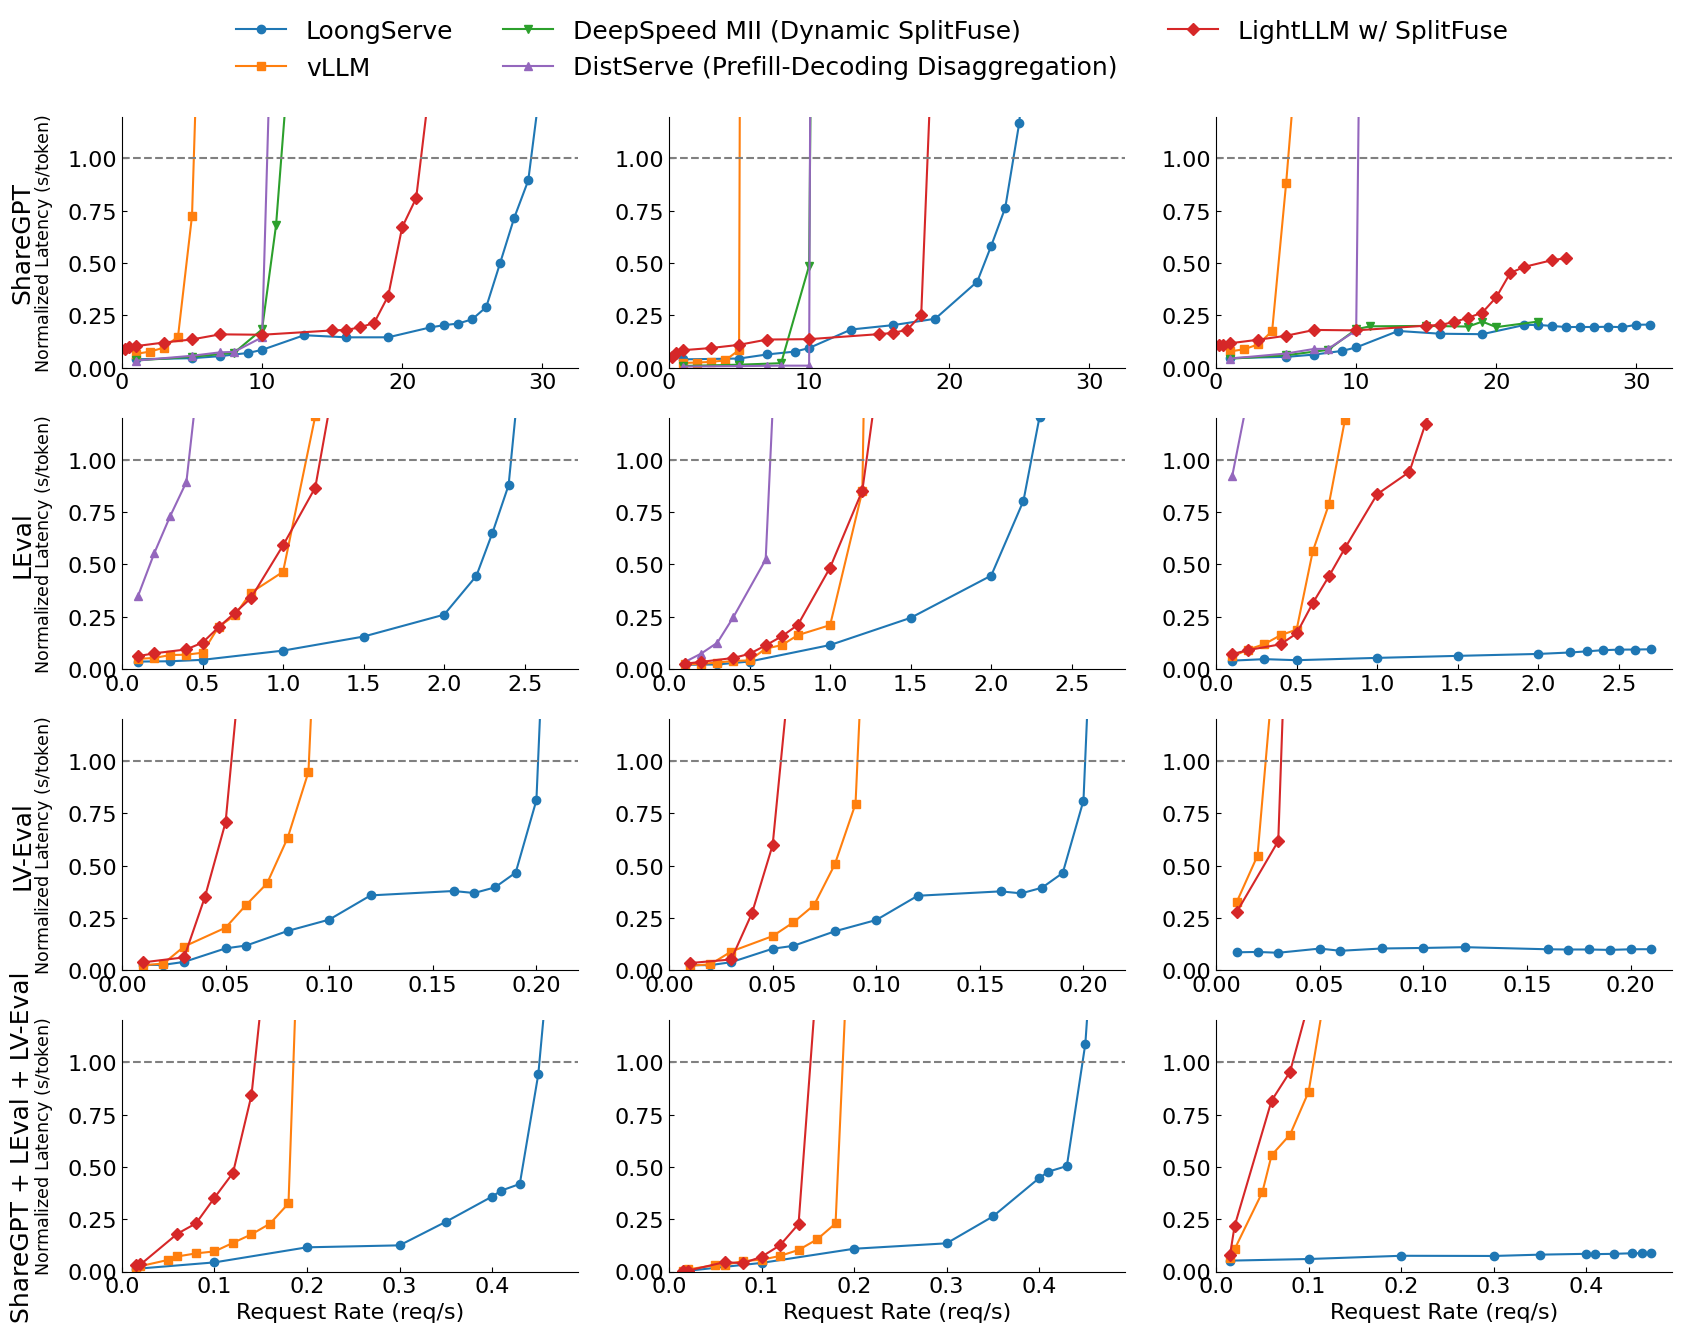

In [43]:
def plot_e2e():
    def draw_one_row_of_plots(
        fig,
        axs: list[mpl_axes.Axes],
        plot_i: int,
        backends: list[BackendConfig],
        row_configs: list[PlotRowConfig],
        col_configs: list[PlotColConfig],
        y_limits: list[list[Union[int, float]]],
        slos: Optional[list[list[Union[int, float]]]] = None,
        normalize_to_slo: bool = False
    ):
        row_config = row_configs[plot_i]
        intersect_xs: list[list[float]] = []
        for (plot_j, col_config) in enumerate(col_configs):
            cur_ax = axs[plot_j]
            cur_y_limit = y_limits[plot_i][plot_j] if plot_i < len(y_limits) and plot_j < len(y_limits[plot_i]) else None
            cur_slo = slos[plot_i][plot_j] if slos is not None and plot_i < len(slos) and plot_j < len(slos[plot_i]) else None

            if cur_y_limit is not None:
                cur_ax.set_ylim(0, cur_y_limit)

            if plot_j == 0:
                cur_ax.set_ylabel(row_config.label_name + "\n" + r"${ }^{\mathrm{Normalized\ Latency\ (s/token)}}$", fontsize=18)
            if plot_i == 3:
                cur_ax.set_xlabel("Request Rate (req/s)")

            if normalize_to_slo and cur_slo is None:
                raise ValueError("When normalize_to_slo is True, slos must be provided")
            cur_intersect_xs = plot_one_latency_rate_plot(cur_ax, row_config.dataset_name, col_config.retriever, backends, plot_i, cur_slo if normalize_to_slo else 1.0, 1.0)
            intersect_xs.append(cur_intersect_xs)

            if plot_i == 0 and plot_j == 0:
                fig.legend(frameon=False, loc="upper center", ncol=3, prop={'size': 18}, bbox_to_anchor=(0.5, 0.96))

            if normalize_to_slo:
                cur_ax.axhline(y=1.0, color='grey', linestyle='--', label="SLO")
            elif cur_slo is not None:
                cur_ax.axhline(y=cur_slo, color='grey', linestyle='--', label="SLO")
            cur_ax.set_xlim(left=0)
            set_xinjin_style(cur_ax)
            
        assert backends[0].label == "LoongServe"
        for (backend_i, backend) in enumerate(backends):
            for (plot_j, col_config) in enumerate(col_configs):
                cur_intersect_xs = intersect_xs[plot_j][backend_i]
                longserve_intersect_xs = intersect_xs[plot_j][0]
                speedup = longserve_intersect_xs / cur_intersect_xs
                print(f"{backend.label} {col_config.title} speedup: {speedup}")
            
    plt.rcParams.update({"font.size": 16})
    backends = [
        BackendConfig("longserve", "LoongServe", "C0", "o"),
        BackendConfig("vllm", "vLLM", "C1", "s"),
        BackendConfig("deepspeed", "DeepSpeed MII (Dynamic SplitFuse)", "C2", "v"),
        BackendConfig("distserve", "DistServe (Prefill-Decoding Disaggregation)", "C4", "^"),
        BackendConfig("lightllm-sf", "LightLLM w/ SplitFuse", "C3", "D"),
    ]
    row_configs = [
        PlotRowConfig("ShareGPT", "ShareGPT"),
        PlotRowConfig("LEval", "LEval"),
        PlotRowConfig("LV-Eval", "LV-Eval"),
        PlotRowConfig("Mixed1", "ShareGPT + LEval + LV-Eval"),
    ]
    col_configs = [
        PlotColConfig("Avg token latency", lambda x, _, row: x.avg_per_token_latency_ms),
        PlotColConfig("Avg input token latency", lambda x, _, row: x.avg_input_token_latency_ms),
        PlotColConfig("Avg output token latency", lambda x, _, row: x.avg_output_token_latency_ms),
    ]

    slos = [
        [92, 20, 320],
        [3.5, 1.8, 320],
        [2.5, 2.5, 365],
        [70, 90, 360]
    ]
    y_limits = [
        [1.2 for x in slos[row]]
        for row in range(len(slos))
    ]
    
    fig, axs = plt.subplots(4, 3, figsize=(20, 15))
    draw_one_row_of_plots(fig, axs[0], 0, backends, row_configs, col_configs, y_limits, slos, normalize_to_slo=True)
    draw_one_row_of_plots(fig, axs[1], 1, backends, row_configs, col_configs, y_limits, slos, normalize_to_slo=True)
    draw_one_row_of_plots(fig, axs[2], 2, backends, row_configs, col_configs, y_limits, slos, normalize_to_slo=True)
    draw_one_row_of_plots(fig, axs[3], 3, backends, row_configs, col_configs, y_limits, slos, normalize_to_slo=True)

    save_fig_to_pdf("evaluation_e2e")
    # axs[1][2].plot([0.1], 1.17, color='purple', marker='o')
    # axs[1][2].annotate(f"y = {294.94815521217987/slos[1][2]}", xy=(0.1, 1.15), xytext=(0.1, 0.9), arrowprops=dict(facecolor='black', shrink=0.1, width=1, headwidth=7))

plot_e2e()

In [9]:
from lib.structs import WorkerParam, InputParam, TestParamGroup
from lib.db import RecordManager

db_dir = "../../db-identical-req.sqlite"
model_dir = "/mnt/petrelfs/wubingyang/intlsy/weights/LWM-Text-1M"
mode = ["_token_decode_attention_overlapped"]

record_manager = RecordManager(filename=db_dir)

# Select one record to verify that the database is loaded correctly
record_manager.cur.execute("SELECT * FROM records LIMIT 1")
print(dict(record_manager.cur.fetchone()))

def fetch_result(
	batch_size: int,
	input_len: int,
	num_sp_master: int,
	need_context_migration: bool,
	num_decoding_stage_migration: int = 0,
	sp_world_size: int = 4,
	tp_world_size: int = 2,
	output_len: int = 16
) -> tuple[float, float]:
	worker_param = WorkerParam(
		model_dir,
		sp_world_size,
		tp_world_size,
		0,
		0,
		0,
		mode
	)
	input_param = InputParam(
		batch_size,
		input_len,
		output_len,
		num_sp_master,
		need_context_migration,
		num_decoding_stage_migration
	)

	cached_result = record_manager.query_record(worker_param, input_param)
	if cached_result is None:
		raise Exception(f"Record {batch_size=} {input_len=} {num_sp_master=} {need_context_migration=} {num_decoding_stage_migration=} {sp_world_size=} {tp_world_size=} {output_len=} not found")
	return cached_result["avg_prefill_time_usage"], cached_result["avg_decoding_time_usage"]
print(fetch_result(1, 100, 1, False))

{'id': 15, 'sp_world_size': 1, 'tp_world_size': 1, 'batch_size': 1, 'input_len': 1000, 'output_len': 16, 'num_sp_master': 1, 'need_context_migration': 0, 'num_decoding_stage_migration': 0, 'avg_prefill_time_usage': 68.88760375976562, 'avg_decoding_time_usage': 13.01193618774414, 'prefill_time_stddev': 0.2077266821374443, 'decoding_time_stddev': 0.05105810686801651, 'tag': "/mnt/petrelfs/wubingyang/intlsy/weights/LWM-Text-1M,['_token_decode_attention_overlapped']"}
(38.4814821879069, 9.755488395690918)


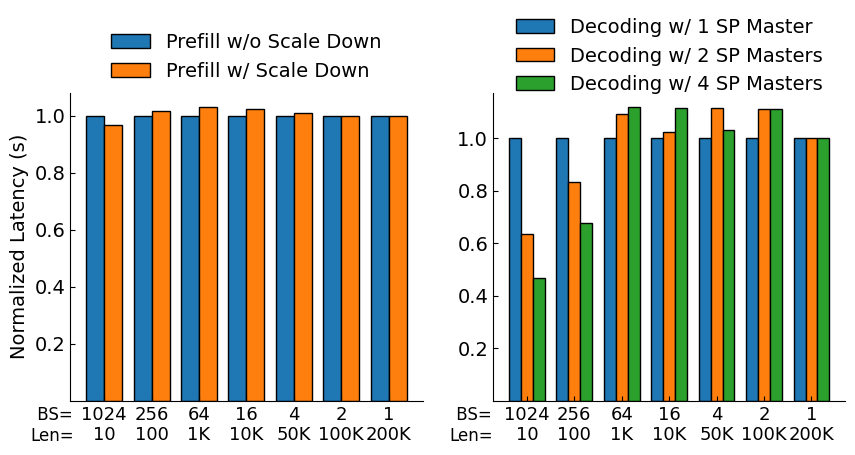

In [10]:
def get_input_len_text(input_len: int) -> str:
	if input_len < 1000:
		return f"{input_len}"
	else:
		return f"{input_len//1000}K"
	
batch_size_and_input_lens = [
	(1024, 10), (256, 100), (64, 1000), (16, 10000), (4, 50000), (2, 100000), (1, 200000)
]
def draw_scale_down_plot(ax: mpl_axes.Axes):
	plt.rcParams.update({"font.size": 14})
	xs_base = np.arange(len(batch_size_and_input_lens))
	bar_width = 0.38
	
	data = np.array([
		[
			fetch_result(batch_size, input_len, 1, perform_context_migration)[0]
			for (batch_size, input_len) in batch_size_and_input_lens
		]
		for perform_context_migration in [False, True]
	])
	data /= data[0]

	for perform_context_migration in [False, True]:
		xs = xs_base + bar_width*(1 if perform_context_migration else 0)
		label = "Prefill w/ Scale Down" if perform_context_migration else "Prefill w/o Scale Down"
		cur_data = data[1 if perform_context_migration else 0]
		ax.bar(xs, cur_data, bar_width, label=label, edgecolor="black")

	xticks = [f"{batch_size}\n{get_input_len_text(input_len)}" for (batch_size, input_len) in batch_size_and_input_lens]
	ax.set_xticks(xs_base + bar_width/2, xticks, size=13)
	set_xinjin_style(ax)
	ax.legend(frameon=False, loc="upper center", ncol=1, bbox_to_anchor=(0.5, 1.25))
	ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
	ax.text(-0.9, -0.02, " BS=\nLen=", ha='center', va='top', color='black', fontsize=12)

def draw_scale_up_plot(ax: mpl_axes.Axes):
	plt.rcParams.update({"font.size": 14})
	num_sp_masters = [1, 2, 4]
	xs_base = np.arange(len(batch_size_and_input_lens))
	bar_width = 0.25
	
	data = np.array([
		[
			fetch_result(batch_size, input_len, num_sp_master, False)[1]
			for (batch_size, input_len) in batch_size_and_input_lens
		]
		for num_sp_master in num_sp_masters
	])
	data /= data[0]

	for (index, num_sp_master) in enumerate(num_sp_masters):
		xs = xs_base + bar_width*(index+0.5)
		label = f"Decoding w/ {num_sp_master} SP Master{'s' if num_sp_master > 1 else ''}"
		cur_data = data[index]
		ax.bar(xs, cur_data, bar_width, label=label, edgecolor="black")

	xticks = [f"{batch_size}\n{get_input_len_text(input_len)}" for (batch_size, input_len) in batch_size_and_input_lens]
	ax.set_xticks(xs_base + bar_width*len(num_sp_masters)/2, xticks, size=13)
	set_xinjin_style(ax)
	ax.legend(frameon=False, loc="upper center", ncol=1, bbox_to_anchor=(0.5, 1.3))
	ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
	ax.text(-0.8, -0.02, " BS=\nLen=", ha='center', va='top', color='black', fontsize=12)

	save_fig_to_pdf("evaluation_ablation_scale_down_up_overhead")

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax0.set_ylabel("Normalized Latency (s)")
draw_scale_down_plot(ax0)
draw_scale_up_plot(ax1)

plt.show()

In [11]:
import math
from lib_benchmark_serving.profiler import Profiler
profiler = Profiler("../../profiler_parameters.csv")

def get_total_slo_attainment(req_results: list[ReqResult], slo: float) -> tuple[float, float]:
    num_valid_tokens = 0
    num_total_tokens = 0
    num_valid_reqs = 0
    num_total_reqs = 0
    for r in req_results:
        num_total_tokens += r.prompt_len + r.output_len - 1
        num_total_reqs += 1
        if r.latency*1000 / (r.prompt_len+r.output_len-1) <= slo:
            num_valid_tokens += r.prompt_len + r.output_len - 1
            num_valid_reqs += 1
    return num_valid_tokens / num_total_tokens, num_valid_reqs / num_total_reqs
    
def check_is_prefill_latency_valid(req_result: ReqResult, tol: float, slo_lower_bound: float) -> bool:
    normal_time_usage = profiler.predict_time_consumption_one_req(req_result.prompt_len)
    slo = max(normal_time_usage * tol, slo_lower_bound)
    return req_result.ttft*1000 <= slo

def get_both_slo_attainment(req_results: list[ReqResult], ttft_tol: float, slo_lower_bound: float, tpot_slo: float) -> tuple[float, float]:
    num_valid_tokens = 0
    num_total_tokens = 0
    num_valid_reqs = 0
    num_total_reqs = 0
    for r in req_results:
        num_total_tokens += r.prompt_len + r.output_len-1
        num_total_reqs += 1
        if check_is_prefill_latency_valid(r, ttft_tol, slo_lower_bound) and r.tpot*1000 <= tpot_slo:
            num_valid_tokens += r.prompt_len + r.output_len-1
            num_valid_reqs += 1
    if num_total_reqs == 0:
        return 1, 1
    return num_valid_tokens / num_total_tokens, num_valid_reqs / num_total_reqs

def get_ttft_slo_attainment(req_results: list[ReqResult], ttft_tol: float, ttft_slo_lower_bound: float) -> tuple[float, float]:
    num_valid_tokens = 0
    num_total_tokens = 0
    num_valid_reqs = 0
    num_total_reqs = 0
    for r in req_results:
        num_total_tokens += r.prompt_len
        num_total_reqs += 1
        if check_is_prefill_latency_valid(r, ttft_tol, ttft_slo_lower_bound):
            num_valid_tokens += r.prompt_len
            num_valid_reqs += 1
    if num_total_reqs == 0:
        return 1, 1
    return num_valid_tokens / num_total_tokens, num_valid_reqs / num_total_reqs

def get_tpot_slo_attainment(req_results: list[ReqResult], slo: float) -> tuple[float, float]:
    num_valid_tokens = 0
    num_total_tokens = 0
    num_valid_reqs = 0
    num_total_reqs = 0
    for r in req_results:
        if r.output_len <= 1:
            continue
        num_total_tokens += r.output_len-1
        num_total_reqs += 1
        if r.tpot*1000 <= slo:
            num_valid_tokens += r.output_len-1
            num_valid_reqs += 1
    if num_total_reqs == 0:
        return 1, 1
    return num_valid_tokens / num_total_tokens, num_valid_reqs / num_total_reqs
    
ablation_ttft_tols = [
    25,
    25,
    25,
    25
]
ablation_ttft_slo_lower_bounds = [
    15000,
    15000,
    15000,
    15000,
]
ablation_tpot_slos = [
    50,
    50,
    50,
    100
]

start initializing Profiler, file: ../../profiler_parameters.csv


Dataset Zipf with a=1.0:

\begin{center}
\begin{tabular}{|c|c|}
\hline
Backend & SLO Rate\\
\hline
LS & 1.122 (1.00x) \\
LS w/o ESP (TP=8) & 0.405 (2.77x) \\
LS w/o ESP (TP=2, SP=4) & 0.481 (2.33x) \\
LS w/o ESP (TP=2) x 4 & 0.360 (3.12x) \\
\hline
\end{tabular}
\end{center}

Dataset Zipf with a=1.2:

\begin{center}
\begin{tabular}{|c|c|}
\hline
Backend & SLO Rate\\
\hline
LS & 2.925 (1.00x) \\
LS w/o ESP (TP=8) & 1.355 (2.16x) \\
LS w/o ESP (TP=2, SP=4) & 1.478 (1.98x) \\
LS w/o ESP (TP=2) x 4 & 1.289 (2.27x) \\
\hline
\end{tabular}
\end{center}

Dataset Zipf with a=1.4:

\begin{center}
\begin{tabular}{|c|c|}
\hline
Backend & SLO Rate\\
\hline
LS & 8.757 (1.00x) \\
LS w/o ESP (TP=8) & 5.723 (1.53x) \\
LS w/o ESP (TP=2, SP=4) & 5.447 (1.61x) \\
LS w/o ESP (TP=2) x 4 & 5.000 (1.75x) \\
\hline
\end{tabular}
\end{center}



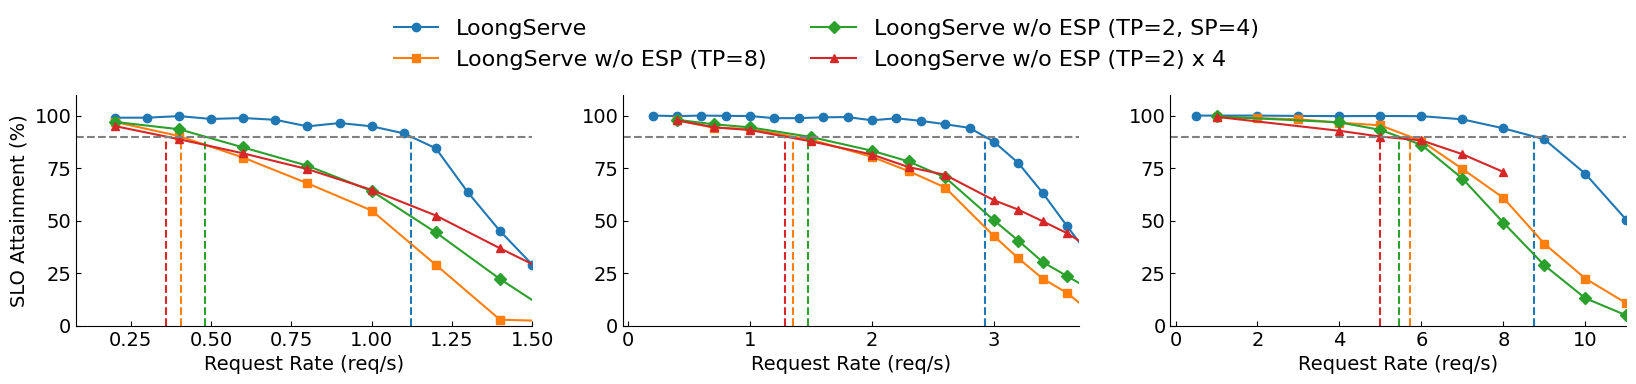

In [40]:
def plot_ablation_slo_atta_with_rate():
    plt.rcParams.update({"font.size": 14})
        
    def draw_one_plot(
        fig,
        ax: mpl_axes.Axes,
        plot_j: int,
        backends: list[BackendConfig],
        row_configs: PlotRowConfig,
        x_limits: list[Union[int, float]],
        retriever: Callable[[BenchmarkMetrics, list[ReqResult], int], float],
    ):
        cur_config = row_configs[plot_j]

        if plot_j == 0:
            ax.set_ylabel("SLO Attainment (%)", fontsize=14)
        ax.set_xlabel("Request Rate (req/s)")

        intersect_xs = []
        for cur_backend in backends:
            cur_xs = []
            cur_ys = []
            for (file_path, _, _, num_prompts, req_rate) in walk_around_exp_results(cur_config.dataset_name, cur_backend.name):
                metrics, req_results = load_metric(file_path)
                cur_xs.append(req_rate)
                cur_ys.append(retriever(metrics, req_results, plot_j))
            ax.plot(cur_xs, cur_ys, label=cur_backend.label, marker=cur_backend.marker, color=cur_backend.color)
            intersect_x = get_intersection_point(cur_xs, cur_ys, 90)
            intersect_xs.append(intersect_x)
            ax.axvline(x=intersect_x, ymin=0, ymax=90/110, color=cur_backend.color, linestyle='--')
   
        if plot_j == 0:
            fig.legend(frameon=False, loc="upper center", ncol=2, prop={'size': 16}, bbox_to_anchor=(0.5, 1.2))

        ax.axhline(y=90, color='grey', linestyle='--', label="SLO")
        ax.set_xlim(right=x_limits[plot_j])
        ax.set_ylim(0, 110)
        set_xinjin_style(ax)
        
        assert backends[0].label == "LoongServe"
        for (backend_i, backend) in enumerate(backends):
            cur_intersect_xs = intersect_xs[backend_i]
            longserve_intersect_xs = intersect_xs[0]
            speedup = longserve_intersect_xs / cur_intersect_xs
            print(f"{backend.label.replace('LoongServe', 'LS')}: {cur_intersect_xs:.3f} ({speedup:.2f}x)", end="")

    backends = [
        BackendConfig("longserve", "LoongServe", "C0", "o"),
        BackendConfig("longserve-fixsp-sp1tp8dp1", "LoongServe w/o ESP (TP=8)", "C1", "s"),
        BackendConfig("longserve-fixsp-sp4tp2dp1", "LoongServe w/o ESP (TP=2, SP=4)", "C2", "D"),
        BackendConfig("longserve-fixsp-sp1tp2dp4", "LoongServe w/o ESP (TP=2) x 4", "C3", "^"),
    ]
    row_configs = [
        PlotRowConfig("zipf1.0", "Zipf with a=1.0"),
        PlotRowConfig("zipf1.2", "Zipf with a=1.2"),
        PlotRowConfig("zipf1.4", "Zipf with a=1.4"),
        PlotRowConfig("zipf1.6", "Zipf with a=1.6"),
    ]
    x_limits = [
        1.5,
        3.7,
        11
    ]
    retriever = lambda x, req_results, row: get_both_slo_attainment(req_results, ablation_ttft_tols[row], ablation_ttft_slo_lower_bounds[row], ablation_tpot_slos[row])[1]*100
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 3))
    draw_one_plot(fig, axs[0], 0, backends, row_configs, x_limits, retriever)
    draw_one_plot(fig, axs[1], 1, backends, row_configs, x_limits, retriever)
    draw_one_plot(fig, axs[2], 2, backends, row_configs, x_limits, retriever)
    
    save_fig_to_pdf("evaluation_ablation_zipf_slo_attainment")

plot_ablation_slo_atta_with_rate()
